In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.table import Table
from bokeh.plotting import *
output_notebook()

import hdbscan

Loading BokehJS ...

In [2]:
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers

## Initialize the cluster object
set query=True if you need to query the data from Gaia or generate the adql for an OC

Prior distance =  1957.392860875564  pc


Search radius for HDBSCAN? (float in degrees) .5
Min cluster size? (int) 10


4627  members in group  -1
13  members in group  0
10  members in group  1
10  members in group  2
14  members in group  3
11  members in group  4
15  members in group  5
34  members in group  6
13  members in group  7
1402  members in group  8
19  members in group  9


Which group? 8


Cluster distance =  1889.4100172106491  pc


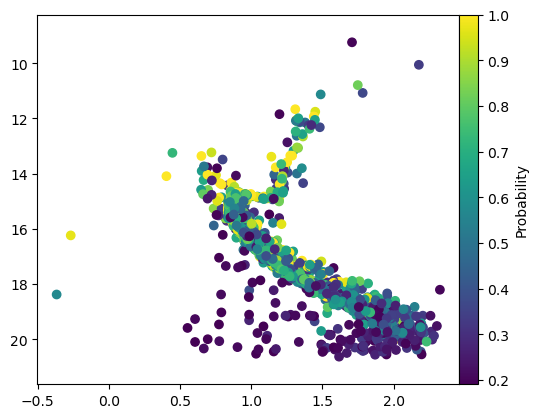

Use this group? (y/n)? n
Search radius for HDBSCAN? (float in degrees) .1
Min cluster size? (int) 5


159  members in group  -1
16  members in group  0
527  members in group  1


Which group? 1


Cluster distance =  1901.0444582429832  pc


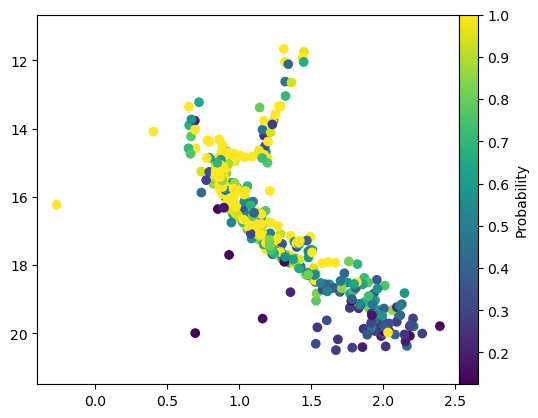

Use this group? (y/n)? y


Parameter('stddev', value=2.711818733619529, bounds=(1.1754943508222875e-38, None)) 4.266266643960783


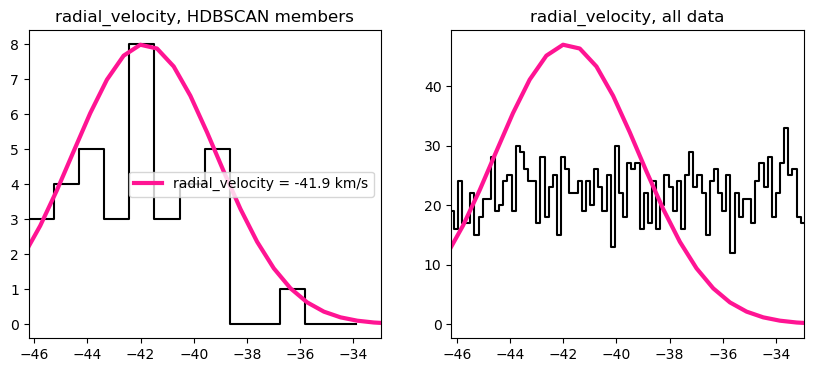

Parameter('stddev', value=126.57292433092758, bounds=(1.1754943508222875e-38, None)) 301.43312672676063


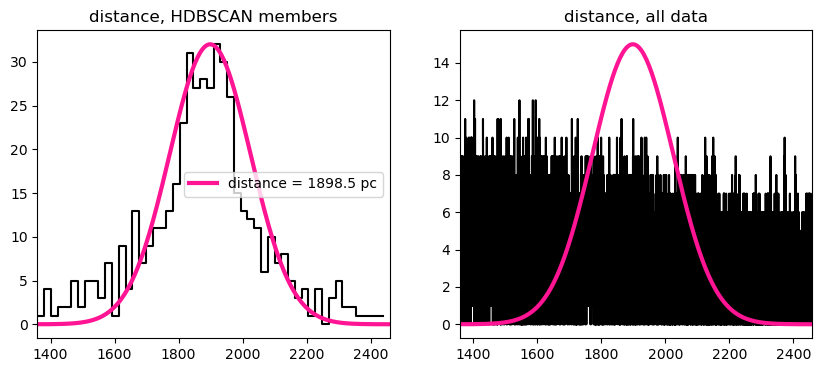

Parameter('stddev', value=0.12134585433289045, bounds=(1.1754943508222875e-38, None)) 0.2550078637037951


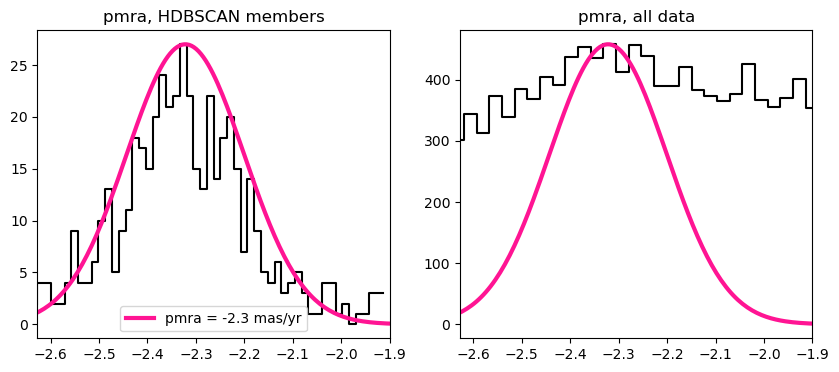

Parameter('stddev', value=0.11528447080497194, bounds=(1.1754943508222875e-38, None)) 0.2377313874654524


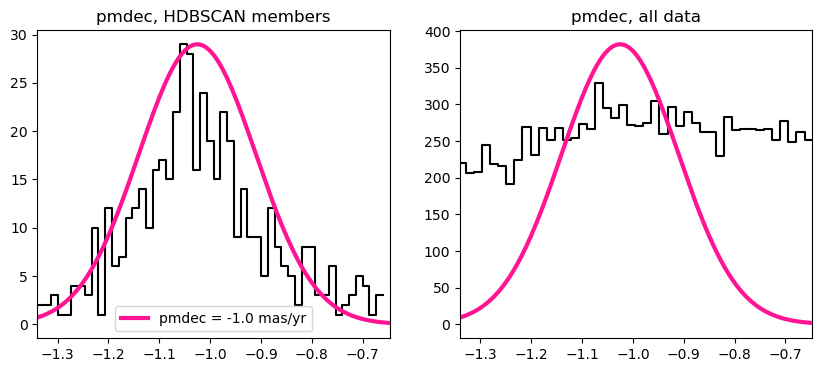

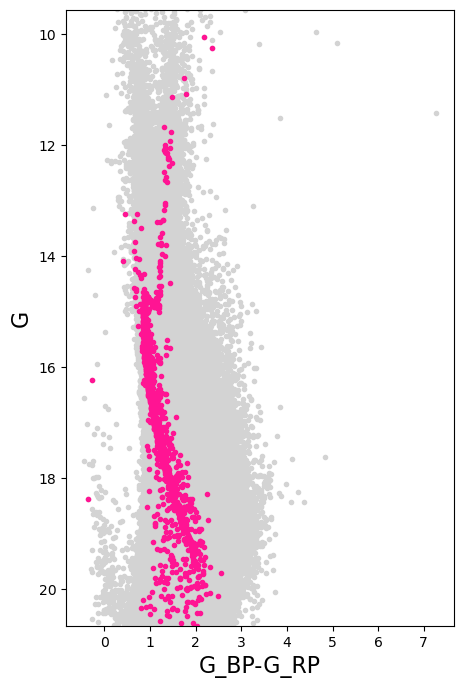

Length of members =  1409
fit parameters :
amplitude = 11.7 +/- 1.24
r_core = 4.45 +/- 0.371
r_tide = 46.2 +/- 1.72


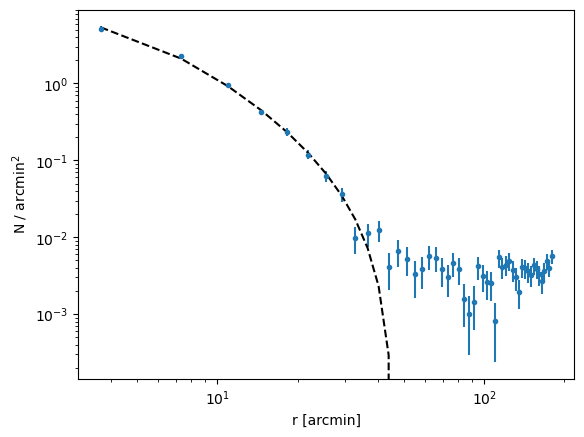

done.


In [5]:
Hunt = pd.read_csv('Hunt2023.tsv',sep='\s+', header=94)

def distance_modulus_to_pc(distance_modulus):
    return 10 ** ((distance_modulus + 5) / 5)

def run_pipeline(clusterName,query=False):
    cluster = GaiaClusterMembers()
    pwd = clusterName+'_dir' #change this pwd as needed
    if os.path.isdir(pwd):
        print("Directory exists.")
    else:
        os.makedirs(pwd)
        os.makedirs(pwd+'/plots')
    cluster.plotNameRoot = pwd+'/plots/'
    cluster.photOutputFileName = pwd +'/'+clusterName + '.phot'
    cluster.saveDataFile = pwd +'/'+clusterName + '.csv'
    cluster.yamlOutputFileName = pwd + '/base9.yaml'
    cluster.yamlTemplateFileName = 'template_base9.yaml'
    
    Hunt_data = Hunt[Hunt['Name']==clusterName]
    cluster.rt = Hunt_data['rt'].values[0]
    Av = round(Hunt_data['AV50'].values[0],5)
    err_Av = round(Hunt_data['AV84'].values[0],5)
    logAge = round(Hunt_data['logAge50'].values[0],5)
    dmod = round(Hunt_data['MOD50'].values[0],5)
    prior_pc = distance_modulus_to_pc(dmod)
    err_dmod = round(Hunt_data['MOD50'].values[0]-Hunt_data['MOD16'].values[0],5)
    start_dmod = dmod
    start_FeH = 0
    start_Av = Av
    start_age = logAge
    cluster.yamlInputDict = {
        'photFile' : clusterName + '.phot',
        'outputFileBase' : clusterName,
        'modelDirectory' : '/projects/p31721/BASE9/base-models/',
        'msRgbModel' : 5,
        'Fe_H' : [start_FeH, 0.0, 0.3, 0.3],
        'Av' : [start_Av, Av, err_Av, 0.3],
        'Y' : [0.29, 0.29, 0.0], # keep the defaults
        'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
        'logAge' : [start_age, logAge, np.inf],
        'distMod' : [start_dmod, dmod, err_dmod],
    }
    
    if query:
        cluster.radius = float(input("What radius to query from Gaia? (Deg)"))
        cluster.query_data(clusterName,pwd+'/'+clusterName+'_GaiaData.ecsv') #run this line to download Gaia data that will be saved to the file clusterName+'_dir/'+clusterName+'_GaiaData.ecsv'
    else:
        prior_pc = distance_modulus_to_pc(dmod)
        print ("Prior distance = ",prior_pc," pc") #I show this as a check that I am looking at the right OC
        cluster.runAll(clusterName,filename= clusterName+'_GaiaData.ecsv') #run this line if Gaia data has already been downloaded  
        cluster.photOutputFileName = pwd+'/'+ clusterName + '_sig1.phot'
        return cluster
cluster = run_pipeline('NGC_188', query=False)

## (optional) Save the cluster object for use later

In [ ]:
import pickle

In [ ]:
with open("cluster_save.pkl", "wb") as file:
    pickle.dump(cluster, file)

## (optional) Read in the cluster object 

In [ ]:
with open("cluster_save.pkl", 'rb') as file:
    cluster = pickle.load(file)

## Add rcenter, gaia phot errors, and convert parallax to distance to files that have been downloaded from Gaia website

In [ ]:
def add_to_download(cluster_name):
    df1 = pd.read_csv('../OC_data/'+cluster_name+'_dir/'+cluster_name+'-result.csv',sep=',') #Downloaded file directly from Gaia website.
    file_path = '../OC_data/'+cluster+'_dir/'+cluster_name+'_GaiaData.ecsv' #New file to write to. Do not want to overwrite the -result.csv file.

    ra = Hunt['RA_ICRS'][Hunt['Name']==cluster]
    dec = Hunt['DE_ICRS'][Hunt['Name']==cluster]
    center = SkyCoord(ra, dec, unit=(units.degree, units.degree))
    sigmaG_0 = 0.0027553202
    sigmaGBP_0 = 0.0027901700
    sigmaGRP_0 = 0.0037793818
    df = Table.from_pandas(df1)
    df['phot_g_mean_mag_error'] = ((-2.5/np.log(10)/df['phot_g_mean_flux_over_error'])**2 + sigmaG_0**2)**0.5
    df['phot_bp_mean_mag_error'] = ((-2.5/np.log(10)/df['phot_bp_mean_flux_over_error'])**2 + sigmaGBP_0**2)**0.5
    df['phot_rp_mean_mag_error'] = ((-2.5/np.log(10)/df['phot_rp_mean_flux_over_error'])**2 + sigmaGRP_0**2)**0.5
    
    df['coord'] = SkyCoord(df['ra'] * units.degree, df['dec']* units.degree, frame='icrs') 
    df['rCenter'] = center.separation(df['coord'])
    df['id'] = df['source_id']
    df['distance'] = (df['parallax'] * units.mas).to(units.parsec, equivalencies=units.parallax()).value
    df['distance_error'] = (df['parallax_error'] * units.mas).to(units.parsec, equivalencies=units.parallax()).value
    df = df.to_pandas()
    df = df.rename(columns={'source_id': 'SOURCE_ID'})
    df.to_csv(file_path, index=False,sep=' ')
add_to_download('NGC_188')

## Use the interactive isochrone tool
Note: This tool works best in a jupyter notebook and will cause problems in VSCode

In [ ]:
layout = cluster.createInteractiveIsochrone(
    'PARSEC.model', 
    initialGuess = [
        float(cluster.yamlInputDict['logAge'][0]), 
        float(cluster.yamlInputDict['Fe_H'][0]),
        float(cluster.yamlInputDict['distMod'][0]),
        float(cluster.yamlInputDict['Av'][0])
    ],
    mag ='phot_g_mean_mag', 
    color1 ='phot_bp_mean_mag', 
    color2 ='phot_rp_mean_mag', 
    xrng = [-4,4], 
    yrng = [24,5]
)

# in order to run a Python callback in a Jupyter notbook, you need to include the following
def bkapp(doc):
    doc.add_root(layout)
    
show(bkapp)